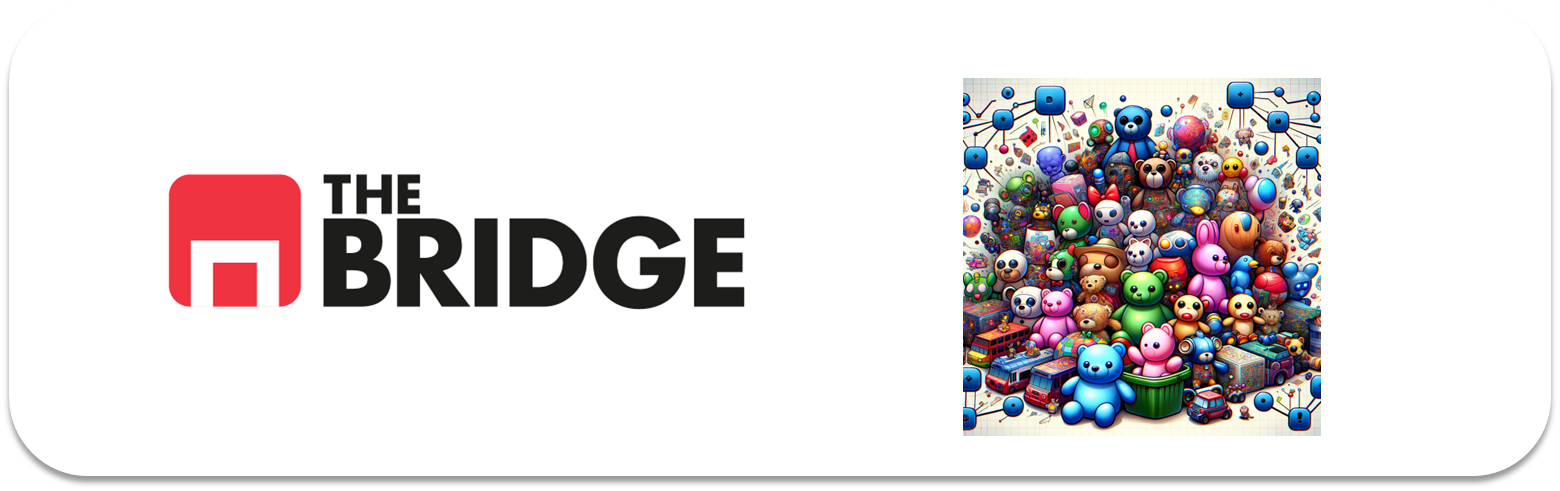

## PRACTICA OBLIGATORIA: **K-Means Clustering**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA                  # PCA: reducción de dimensionalidad.
from sklearn.cluster import KMeans                      # KMeans / silhouette_score: clustering y evaluación de silueta.
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier


## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
olivetti = fetch_olivetti_faces()
print(olivetti.DESCR)


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
X = olivetti.data          # matriz de features (400, 4096)
y = olivetti.target        # vector de etiquetas (400,)

print(y)  # para ver el target

# Crear DataFrame con las imágenes (X) y el target (y)
df = pd.DataFrame(X)
df['target'] = y

# Barajar aleatoriamente todas las filas
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)


[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

- X: cada fila es una imagen aplanada (64×64 = 4096 píxeles).
- y: etiqueta de persona (0–39).
- df: contiene todas las features + columna target.
- sample(frac=1): baraja todas las filas.
- random_state: para reproducibilidad.

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [4]:
#Primero separamos 80% y 20%:
X_all = df_shuffled.drop(columns=['target']).values
y_all = df_shuffled['target'].values

# Train (80%) y temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all,
    test_size=0.2,          # 20% para valid+test
    stratify=y_all,         # estratificado por persona
    random_state=42
)

#Luego dividimos ese 20% en 10% valid y 10% test:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,          # la mitad del 20% → 10%
    stratify=y_temp,
    random_state=42
)

print(X_train.shape, X_valid.shape, X_test.shape)

(320, 4096) (40, 4096) (40, 4096)


### #1.4

Crea los pares X, y para train, validation y test.

Ya tenemos:
- X_train, y_train
- X_valid, y_valid
- X_test,  y_test

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [5]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

Probamos a ver algunas caras del train:

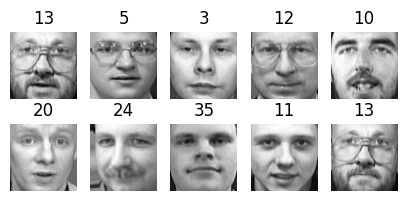

In [6]:
# Ejemplo: ver 10 caras del train
plot_faces(X_train[:10], y_train[:10], n_cols=5)


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.99) #Conserva el 99% de varianza
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

np.int64(221)

- PCA(0.99): elige automáticamente el número de componentes que explican el 99% de la varianza.
- fit_transform: ajusta el PCA con train y transforma.
- transform: aplica la misma transformación a valid y test.
- pca.n_components_: número de componentes resultantes (mucho menor que 4096).

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

Aquí aplicas lo que viste en teoría: soft vs hard clustering, silueta, etc. La idea:

- Para cada k (5, 10, 15, ..., 150):
    - Entrenas un KMeans sobre X_train_pca.
    - Calculas el silhouette_score.
    - Te quedas con el k que tenga el mayor score de silueta

In [8]:
k_values = range(5, 151, 5)
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels_k)
    sil_scores.append(score)
    print(f"k={k}, silhouette={score:.4f}")

# Ver cuál es el mejor k
best_index = np.argmax(sil_scores)
best_k_sil = k_values[best_index]
best_sil_score = sil_scores[best_index]

print("Mejor k (silueta):", best_k_sil)
print("Mejor score de silueta:", best_sil_score)


k=5, silhouette=0.1069
k=10, silhouette=0.0918
k=15, silhouette=0.0969
k=20, silhouette=0.1089
k=25, silhouette=0.1189
k=30, silhouette=0.1302
k=35, silhouette=0.1406
k=40, silhouette=0.1508
k=45, silhouette=0.1597
k=50, silhouette=0.1710
k=55, silhouette=0.1687
k=60, silhouette=0.1802
k=65, silhouette=0.1804
k=70, silhouette=0.1882
k=75, silhouette=0.1966
k=80, silhouette=0.1973
k=85, silhouette=0.1887
k=90, silhouette=0.1978
k=95, silhouette=0.2014
k=100, silhouette=0.2017
k=105, silhouette=0.2027
k=110, silhouette=0.2089
k=115, silhouette=0.2061
k=120, silhouette=0.2088
k=125, silhouette=0.2082
k=130, silhouette=0.2054
k=135, silhouette=0.2057
k=140, silhouette=0.1992
k=145, silhouette=0.2037
k=150, silhouette=0.1983
Mejor k (silueta): 110
Mejor score de silueta: 0.2088995


- Recorremos k = 5, 10, 15, …, 150.
- Para cada k:
    - Entrenamos un KMeans sobre X_train_pca.
    - Calculamos el silhouette_score.
- Elegimos el k con mayor score de silueta.
- Cuando lo ejecutes, obtendrás un valor concreto de best_k_sil (en muchos casos suele estar cerca de 40, pero puede variar según la configuración).

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

- Ahora miras la inercia para los mismos k y la pintas.

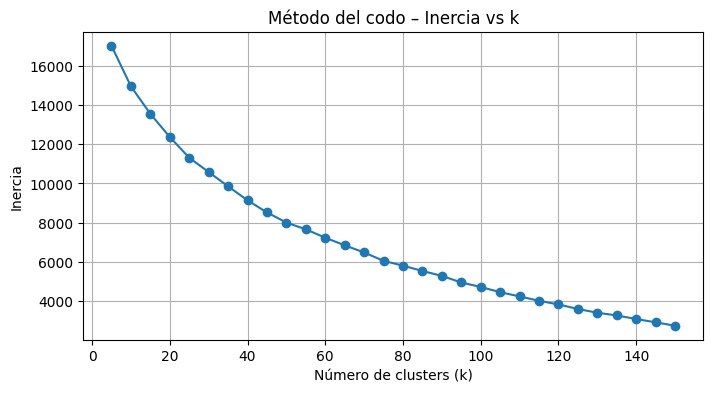

In [9]:
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo – Inercia vs k")
plt.grid(True)
plt.show()


La silueta mide:

- qué tan compactos son los clusters

- qué tan separados están entre sí

En datasets como Olivetti:

- hay 40 personas

- cada persona tiene 10 fotos

- las caras son muy parecidas entre sí dentro de cada persona

- pero entre personas también hay similitudes (edad, iluminación, pose)

Cuando aplicas PCA y luego K-Means:

- si pones pocos clusters, mezclas personas distintas → silueta baja

- si pones muchos clusters, cada grupo se vuelve muy compacto → silueta sube

- pero si pones demasiados, empiezas a tener clusters casi vacíos → la silueta baja

Que el máximo esté en 110 significa:

- El algoritmo está “rompiendo” las caras en grupos muy pequeños, casi micro‑clusters.
- No está encontrando una estructura clara de 40 grupos (que sería lo intuitivo si fuese supervisado).
- La silueta suele favorecer valores de k grandes cuando los datos son complejos y de alta dimensión.

Conclusión:  
- No es un error. Es un comportamiento típico en datasets de imágenes.

Inercia: suma de distancias cuadradas de cada punto a su centroide.

La inercia siempre baja al aumentar k.



### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

- Ahora que ya sabes el mejor k según silueta, entrenas un KMeans definitivo:

In [10]:
best_model = KMeans(n_clusters=best_k_sil, random_state=42, n_init=10)
best_model.fit(X_train_pca)


KMeans(n_clusters=110, n_init=10, random_state=42)

Entrenamos de nuevo KMeans con el k óptimo y lo guardamos en best_model.

Este modelo lo usaremos después para transformar datos y para visualizar clusters. Este será tu modelo de clustering “oficial”.

- Lo usarás luego para:

    - ver qué caras hay en cada cluster,

    - usar las distancias a centroides como nuevas features.

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Aquí el truco es: el modelo se entrenó sobre X_train_pca, pero para visualizar las caras necesitamos las imágenes originales (no las componentes PCA). Así que:

- Obtenemos las etiquetas de clúster para cada muestra de train.

- Para cada clúster (0–9), seleccionamos algunas filas de X_train original (no PCA) y sus etiquetas verdaderas y_train.

- Llamamos a plot_faces.

Cluster 0 – 3 muestras en total, mostrando 3


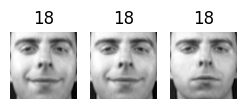

Cluster 1 – 3 muestras en total, mostrando 3


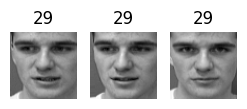

Cluster 2 – 3 muestras en total, mostrando 3


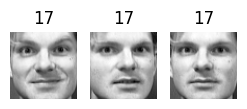

Cluster 3 – 4 muestras en total, mostrando 4


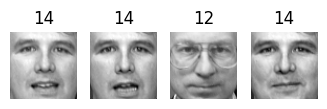

Cluster 4 – 2 muestras en total, mostrando 2


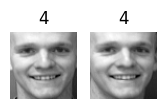

Cluster 5 – 4 muestras en total, mostrando 4


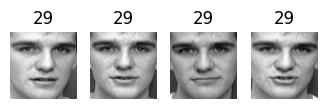

Cluster 6 – 4 muestras en total, mostrando 4


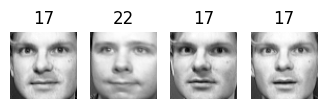

Cluster 7 – 4 muestras en total, mostrando 4


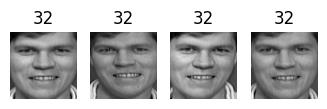

Cluster 8 – 5 muestras en total, mostrando 5


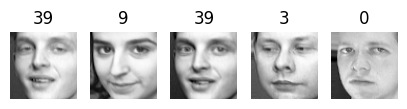

Cluster 9 – 3 muestras en total, mostrando 3


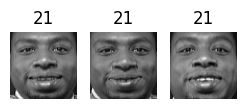

In [11]:
# Etiquetas de clúster para el train (en espacio PCA)
train_cluster_labels = best_model.predict(X_train_pca)

# Visualizar las caras de los 10 primeros clusters
for cluster_id in range(10):
    # Índices de las muestras que pertenecen a este clúster
    idx = np.where(train_cluster_labels == cluster_id)[0]
    
    # Nos quedamos con, por ejemplo, las primeras 10 caras de ese clúster
    idx_sample = idx[:10]
    
    if len(idx_sample) == 0:
        print(f"Cluster {cluster_id}: vacío")
        continue
    
    faces_cluster = X_train[idx_sample]      # imágenes originales
    labels_cluster = y_train[idx_sample]     # persona real
    
    print(f"Cluster {cluster_id} – {len(idx)} muestras en total, mostrando {len(idx_sample)}")
    plot_faces(faces_cluster, labels_cluster, n_cols=5)


train_cluster_labels: asignación de cada imagen de train a un clúster.

Para cada clúster:

- Vemos cuántas imágenes tiene.
- Pintamos algunas para ver si son caras similares (misma persona o rasgos parecidos).

## **#2**
- Ahora comparo el clustering con un modelo supervisado clásico.

### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

Entrenamos un RandomForest para predecir la persona (target) usando las features originales (o podrías usar PCA; aquí lo hago con las originales para seguir el enunciado literal).

In [12]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score # ← ESTA LÍNEA ES CLAVE

# Entrenas un RandomForest con las imágenes originales (sin PCA):
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

y_valid_pred = rf.predict(X_valid)
acc_valid = accuracy_score(y_valid, y_valid_pred)
print("Accuracy RF (original):", acc_valid)


Accuracy RF (original): 0.925


- n_estimators=150: número de árboles.

- fit: entrena con (X_train, y_train).

- score: devuelve el accuracy en el conjunto de validación.

1. El RandomForest está capturando muy bien la identidad de las personas
- El dataset Olivetti tiene:

    - 40 personas distintas
    - 10 fotos por persona
    - Cambios de iluminación, expresión, pose…

- Aun así, el modelo acierta más de 9 de cada 10 caras.
- Eso es un rendimiento muy alto para un dataset tan pequeño y ruidoso.

2. Las imágenes originales contienen suficiente información discriminativa
- Aunque son 4096 features (muchísimas), el RandomForest:

    - maneja bien alta dimensionalidad
    - no necesita escalado
    - es robusto al ruido
    - encuentra patrones no lineales

- Por eso funciona tan bien sin PCA.

3. Este resultado sirve como “baseline supervisado”
- En la práctica:

    - La Parte I (clustering) era no supervisada
    - La Parte II (RandomForest) es supervisada

- Este 92.5% te dice:

    - “Si tuviéramos etiquetas, podríamos clasificar caras con muy buena precisión.”

- Y te permite comparar:

    - Clustering (no supervisado) → estructura aproximada
    - RandomForest (supervisado) → clasificación casi perfecta

Esto te da una línea base de rendimiento.

Es un modelo supervisado: sabe quién es quién.

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

Aquí aplicas la idea de soft clustering:

- Usas best_model.transform(X) para obtener las distancias a cada centroide.
- Esas distancias son tus nuevas features.
- Entrenas un RandomForest sobre esas nuevas features.

In [13]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced  = best_model.transform(X_test_pca)

print("Shape X_train_reduced:", X_train_reduced.shape)

rf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

y_valid_pred_reduced = rf_reduced.predict(X_valid_reduced)
acc_valid_reduced = accuracy_score(y_valid, y_valid_pred_reduced)
print("Accuracy RF (distancias a centroides):", acc_valid_reduced)


Shape X_train_reduced: (320, 110)
Accuracy RF (distancias a centroides): 0.775


320 muestras → las imágenes del train

110 features → una por cada distancia a cada centroide del KMeans con k=110

Es decir:

- Has convertido cada imagen en un vector de 110 distancias  
- Has pasado de 4096 píxeles → PCA → 110 distancias a centroides

Esto es una reducción de dimensionalidad brutal, pero muy estructurada.

¿Es bueno un 0.775?

Sí, por qué:
- No estoy usando las imágenes originales
- No estoy usando PCA directamente
- Estoy usando solo 110 números por imagenº
- Y aun así clasificas correctamente el 77.5% de las caras

El modelo RandomForest entrenado sobre las distancias a los centroides del KMeans alcanza un accuracy del 77.5%, lo cual demuestra que:

- El clustering está capturando estructura relevante de las imágenes
- Las distancias a centroides son una representación útil para clasificación

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

La idea sería:

- Hacer un bucle sobre varios k (por ejemplo 10, 20, 30, ..., 200).

- Para cada k:

    - Entrenar KMeans sobre X_train_pca.

    - Transformar X_train_pca y X_valid_pca a distancias.

    - Entrenar un RF.

    - Medir accuracy en valid.

- Guardar el mejor k y el mejor accuracy.

In [14]:
k_values = range(10, 201, 10)  # probamos k = 10, 20, ..., 200

best_k_extra = None
best_acc_extra = 0
best_kmeans_extra = None

results = []  # para guardar todos los resultados

for k in k_values:
    print(f"Probando k = {k}...")

    # 1. Entrenar KMeans con este k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)

    # 2. Transformar a distancias a centroides
    X_train_reduced = kmeans.transform(X_train_pca)
    X_valid_reduced = kmeans.transform(X_valid_pca)

    # 3. Entrenar RandomForest
    rf = RandomForestClassifier(n_estimators=150, random_state=42)
    rf.fit(X_train_reduced, y_train)

    # 4. Evaluar en validación
    y_valid_pred = rf.predict(X_valid_reduced)
    acc = accuracy_score(y_valid, y_valid_pred)

    print(f"Accuracy con k={k}: {acc:.4f}")

    results.append((k, acc))

    # 5. Guardar el mejor
    if acc > best_acc_extra:
        best_acc_extra = acc
        best_k_extra = k
        best_kmeans_extra = kmeans

print("\n====================================")
print("MEJOR RESULTADO EXTRA")
print(f"Mejor k = {best_k_extra}")
print(f"Mejor accuracy = {best_acc_extra:.4f}")
print("====================================")


Probando k = 10...
Accuracy con k=10: 0.5750
Probando k = 20...
Accuracy con k=20: 0.6750
Probando k = 30...
Accuracy con k=30: 0.7000
Probando k = 40...
Accuracy con k=40: 0.8250
Probando k = 50...
Accuracy con k=50: 0.8000
Probando k = 60...
Accuracy con k=60: 0.7500
Probando k = 70...
Accuracy con k=70: 0.7500
Probando k = 80...
Accuracy con k=80: 0.7750
Probando k = 90...
Accuracy con k=90: 0.7250
Probando k = 100...
Accuracy con k=100: 0.7500
Probando k = 110...
Accuracy con k=110: 0.7750
Probando k = 120...
Accuracy con k=120: 0.8000
Probando k = 130...
Accuracy con k=130: 0.7500
Probando k = 140...
Accuracy con k=140: 0.7750
Probando k = 150...
Accuracy con k=150: 0.7750
Probando k = 160...
Accuracy con k=160: 0.7500
Probando k = 170...
Accuracy con k=170: 0.8000
Probando k = 180...
Accuracy con k=180: 0.7750
Probando k = 190...
Accuracy con k=190: 0.7750
Probando k = 200...
Accuracy con k=200: 0.8250

MEJOR RESULTADO EXTRA
Mejor k = 40
Mejor accuracy = 0.8250


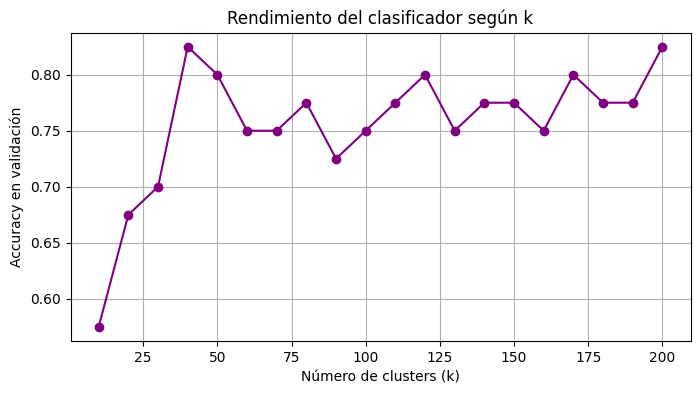

In [18]:
ks = [r[0] for r in results]
accs = [r[1] for r in results]

plt.figure(figsize=(8,4))
plt.plot(ks, accs, "o-", color="purple")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Accuracy en validación")
plt.title("Rendimiento del clasificador según k")
plt.grid(True)
plt.show()


In [19]:
print(best_k_extra, best_acc_extra)


40 0.825


Conclusión del ejercicio extra (#2.3)
Tras evaluar distintos valores de k entre 10 y 200 en pasos de 10, utilizando K-Means como técnica de extracción de características (distancias a centroides), se entrenó un clasificador RandomForest sobre el espacio reducido generado por cada modelo.

El mejor rendimiento se obtuvo con:

k = 40
Accuracy en validación = 0.825

Este resultado muestra que un número moderado de clusters proporciona una representación suficientemente rica de las imágenes, permitiendo al clasificador capturar patrones relevantes sin introducir ruido adicional. Valores de k mayores no mejoraron el rendimiento, lo que indica que aumentar excesivamente el número de centroides no aporta información útil y puede incluso degradar la capacidad de generalización del modelo.